In [62]:
# Import useful things

import numpy as np      
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
from matplotlib import rcParams
import matplotlib.dates as md
import os
import glob
import sys
sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')

from ace_parse import *
from utils import * 


# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='8'
rcParams['ytick.major.pad']='8'

# Supress warnings for notebook ease of use
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Get sodar data from k9

# Sync all data
# rsync -azvp --progress eehgu@k9.leeds.ac.uk:/home/earrn/foe-data-16/GREENLAND/ICECAPSarchive/sodar/raw/20* /Volumes/Data/ICECAPSarchive/SODAR

# Unzip


In [4]:


dloc = '/Users/heather/Desktop/temp_data/temp_sodar_data/'
#'/Volumes/Data/ICECAPSarchive/MMCR/'

# Date of interest
year = '2019'
date = dt.datetime(2019,8,10)
day_of_year = date.timetuple().tm_yday

sodar = Dataset(dloc +'%s%s_SodarPC.nc'%(str(date.year)[-2:],day_of_year),'r')
    

In [5]:
# RecordDelay (milliseconds) - 1D
# Delay between Transmit and begining of recording, Just one value, 40 milliseconds
RecordDelay = sodar.variables['RecordDelay'][:]

ReflectivityData = sodar.variables['ReflectivityData'][:]
# Not sure of units. For now am going to assume that it's 'raw backscatter intensity'

Times = sodar.variables['Time']
dtimes = netCDF4.num2date(Times[:],'seconds since 1970-01-01 00:00:00 0:00')

#create height array (from icecaps quicklooks matlab coad)
Heights = sodar.dimensions['MaxNumberOfReflectivityHeights']
sodarheight1 = np.arange(0,len(Heights),1) # %float vector range
sodarheight = sodarheight1*0.3125+0.3125   # %convert float vector heights to meters

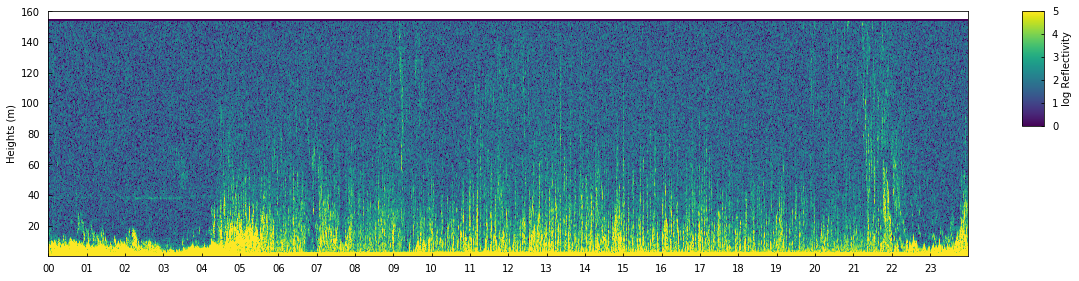

In [6]:

# Plot raw sodar backscatter

fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(111)
rf = ax1.pcolormesh(dtimes,sodarheight,np.transpose(np.log(ReflectivityData)),vmin=0,vmax=5) 
ax1.set_ylabel('Heights (m)')
ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=1))

#ax1.set_ylim(0,12000)



fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cbar_ax1 = fig.add_axes([0.95, 0.55, 0.02, 0.4])
#cbar_ax2 = fig.add_axes([0.95, 0.05, 0.02, 0.4])
fig.colorbar(rf,cax=cbar_ax1,label='log Reflectivity')
#fig.colorbar(dp,cax=cbar_ax2,label='Mean Doppler Velocity, m/s')


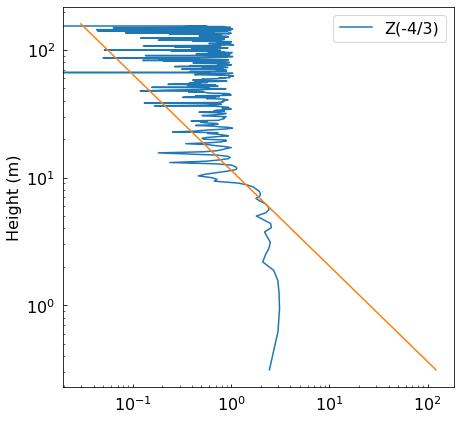

In [107]:
# At one time, plot logR against height

# pick a time
in_time1 = dt.datetime(2019,8,10,2,50,0)
in_time2 = dt.datetime(2019,8,10,2,50,10)

plot_times = pd.date_range(in_time1,in_time2,freq='1s')


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111) 

for i in range(0,1):
    rf_subset = ReflectivityData[np.where(dtimes == plot_times[i])[0],:][0]
    ax1.plot(np.log10(rf_subset),sodarheight, label='Z(-4/3)')

ax1.set_ylabel('Height (m)')

ax1.plot(CT2,sodarheight)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
#ax1.set_ylim(0,100)
#ax1.set_xlim(0.1,4)




In [86]:

# Get Met data     
w_dloc = '/Volumes/Data/ICECAPSarchive/Summit_Met/met_sum_insitu_1_obop_minute_%s_%s.txt'%(date.year,str(date.month).zfill(2))
met = get_NOAA_met(w_dloc)
idat = in_time1 - dt.timedelta(in_time1.second)
P = met.loc[idat]['pres'] * 100
T = met.loc[idat]['T'] + 273.15


Worflow for getting mixed layer depth from sodar: 

1) Calculate a CT2 calibration factor for the sodar. 
   This should be for a period when conditions are convective and BL is well mixed, only
   the well mixed portion should be used for the calibration. 
   Also the calibration will change every time the sodar is restarted...
2) Calculate CT2 by applying the calibration factor to the raw sodar backscatter. 
3) Calculate the mixed layer depth by finding the gradient of CT2 with height. 
   Find whenever this gradient is > -4/3 in log space (for two consecutive points)
   The lowest one of these is = mixed layer depth. 

Well mixed layer: Change of Ct2 with height is ~ -4/3
If change of ct2 with height is positive = stable layer

The temperature structure parameter is:
CT2 = mean([T(x) - T(x+r)]**2) / r** (2/3)
T(x) - T(x+r) = temperature at points x and x+r. 

In [99]:
# From sodar_CT2_calibration.m ~ IMB 2009. 

# CT2 = Temperature structure parameter
# CT2 = backscatter / ct2cal
# ct2cal = altitude dependant calibration factor for determining CT2 profiles from sodar backscatter. 
# Calibration factors will change if sodar gets restarted. 

#  The data chosen for undertaking calibration should be from a period when
#  conditions are convective and the BL is well mixed. Only the well mixed
#  portion of the profile should be used for the calibration.

#  If the boundary layer is well mixed: 
#  CT2 = 2.7 * (theta/g)**(2/3) * H0**(4/3) * z**(-4/3)

# We also need: 
# H0, Kinematic heat flux ( K m/s). H0 = Hs / (rho * Cp)
# Theta, Surface potential temperature (K)

P0 = 100000 # Pa
RdivCp = 0.286
theta = T * (P0/P) ** (RdivCp)
H0 = 150 # for testing assume constant

backscatter = ReflectivityData
z = sodarheight

g = 9.81 # m/s, acceleration due to gravity. 

CT2 = 2.7 * (theta/g)**(2/3) * H0**(4/3) * z**(-4/3)

# Calibration factor
ct2cal = backscatter/CT2


# Average calibrations in altitude bins. 

In [35]:
# Get mixing layer depth from CT2
# sodar_CT2_ML_depth.m
# IMB

# sodar operates on fixed range gates, so single value OK
dZ= z[1] - z[0]
Zd = z[1:len(z)] - dZ/2 # midpoints
dlogz = np.diff(np.log10(z))
#dlogCT2dlogz = np.diff(np.log10(CT2))/(dlogZ)..


In [92]:
np.shape(CT2)

(512,)

In [ ]:
# Plot calbirated sodar backscatter
# Height versus log10(C2T)